In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from pandasql import sqldf
import os
path = os.path.expanduser("~/Documents/m6A/Data")

### m6A peaks and nonpeaks

In [2]:
m6A_peaks = pd.read_table(f"{path}/metApeakFisher_jointpeaks_unmergebins_56lcls/unmerged_peaks_metApeak.bed", 
                          header = 0)
m6A_nonpeaks = pd.read_table(f"{path}/metApeakFisher_jointpeaks_unmergebins_56lcls/unmerged_nonpeaks_metApeak.bed",
                          header = 0)

In [3]:
m6A_peaks = m6A_peaks.sort_values(by = ["# chr", "chromStart"])
m6A_nonpeaks = m6A_nonpeaks.sort_values(by = ["# chr", "chromStart"])
m6A_peaks = m6A_peaks.rename(columns = {"# chr": "chr"})
m6A_nonpeaks = m6A_nonpeaks.rename(columns = {"# chr": "chr"})

In [4]:
peak_name = list(set(m6A_peaks["name"].tolist()))
nonpeak_name = list(set(m6A_nonpeaks["name"].tolist()))
uniq_peak_name = [name for name in peak_name if name not in nonpeak_name]
uniq_nonpeak_name = [name for name in nonpeak_name if name not in peak_name]
intersect_name = list(set(m6A_peaks["name"]) & set(m6A_nonpeaks["name"]))
union_name = list(set(m6A_peaks["name"]) | set(m6A_nonpeaks["name"]))

In [5]:
len(uniq_peak_name), len(uniq_nonpeak_name), len(intersect_name), len(union_name)

(108, 14377, 10633, 25118)

### RBP binding sites

In [6]:
RBP_binding_sites = pd.read_table(f"{path}/all.RBP.intersect.hg19.bed", sep="\t", header = None, 
                                  names = ["chr", "start", "end", "name", "peak_width", "strand"])
peak_width = RBP_binding_sites["peak_width"].tolist()

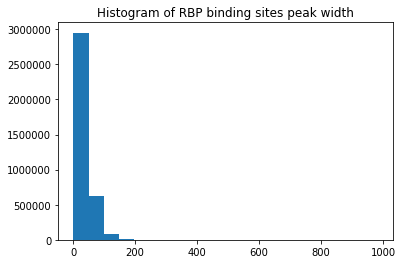

In [7]:
plt.hist(peak_width, bins = 20)  # arguments are passed to np.histogram
plt.title("Histogram of RBP binding sites peak width")
plt.show()

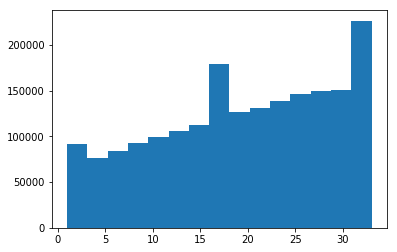

In [8]:
median = np.median(peak_width)
peak_width_low = [item for item in peak_width if item <= median]
plt.hist(peak_width_low, bins = 15)
plt.show()
# peak_width_high = [item for item in peak_width if item >= 400]
# plt.hist(peak_width_high, bins = 20)
# plt.show()

### Check whether RBP binding sites are more common in m6A sites

In [13]:
query = """
    SELECT peaks.chr, peaks.chromStart, peaks.chromEnd, peaks.name, peaks.score, rbp.chr, rbp.start, rbp.end, rbp.name, rbp.peak_width, rbp.strand
    FROM m6A_peaks peaks LEFT JOIN RBP_binding_sites rbp
    WHERE peaks.chr == "chrY" AND rbp.chr == "chrY"
    AND (
    (rbp.start >= peaks.chromStart AND rbp.start <= peaks.chromEnd)
    OR
    (rbp.end >= peaks.chromStart AND rbp.end <= peaks.chromEnd)
    OR
    (rbp.start <= peaks.chromStart AND rbp.end >= peaks.chromEnd)
    )
"""

In [14]:
peaks_Y = sqldf(query)

In [15]:
peaks_Y.head(n = 20)

,chr,chromStart,chromEnd,name,score,chr,start,end,name,peak_width,strand
0,chrY,2710235,2712119,RPS4Y1,0.61,chrY,2710203,2710241,BCCIP,39,+
1,chrY,2710235,2712119,RPS4Y1,0.61,chrY,2710205,2710239,GRWD1,35,+
2,chrY,2710235,2712119,RPS4Y1,0.61,chrY,2710205,2710246,EIF3D,42,+
3,chrY,2710235,2712119,RPS4Y1,0.61,chrY,2710205,2710276,EIF3H,72,+
4,chrY,2710235,2712119,RPS4Y1,0.61,chrY,2710235,2710253,NOL12,19,+
5,chrY,2712118,2712168,RPS4Y1,0.64,chrY,2712126,2712133,EIF3H,8,+
6,chrY,2712118,2712168,RPS4Y1,0.64,chrY,2712132,2712143,GRWD1,12,+
7,chrY,2712118,2712168,RPS4Y1,0.64,chrY,2712165,2712298,GRWD1,134,+
8,chrY,2722661,2722711,RPS4Y1,0.56,chrY,2722666,2722696,GRWD1,31,+
9,chrY,2722661,2722711,RPS4Y1,0.56,chrY,2722669,2722704,SRSF9,36,+


In [18]:
query_non_peaks = """
    SELECT nonpeaks.chr, nonpeaks.chromStart, nonpeaks.chromEnd, nonpeaks.name, nonpeaks.score, rbp.chr, rbp.start, rbp.end, rbp.name, rbp.peak_width, rbp.strand
    FROM m6A_nonpeaks nonpeaks LEFT JOIN RBP_binding_sites rbp
    WHERE nonpeaks.chr == "chrY" AND rbp.chr == "chrY"
    AND (
    (rbp.start >= nonpeaks.chromStart AND rbp.start <= nonpeaks.chromEnd)
    OR
    (rbp.end >= nonpeaks.chromStart AND rbp.end <= nonpeaks.chromEnd)
    OR
    (rbp.start <= nonpeaks.chromStart AND rbp.end >= nonpeaks.chromEnd)
    )
"""

In [19]:
non_peaks_Y = sqldf(query_non_peaks)

In [20]:
non_peaks_Y

,chr,chromStart,chromEnd,name,score,chr,start,end,name,peak_width,strand
0,chrY,2722761,2722811,RPS4Y1,0.65,chrY,2722770,2722813,PPIG,44,+
1,chrY,2722761,2722811,RPS4Y1,0.65,chrY,2722777,2722813,GRWD1,37,+
2,chrY,2722761,2722811,RPS4Y1,0.65,chrY,2722797,2722802,GRSF1,6,+
3,chrY,2722761,2722811,RPS4Y1,0.65,chrY,2722799,2722812,EIF3D,14,+
4,chrY,2722810,2733176,RPS4Y1,0.70,chrY,2722770,2722813,PPIG,44,+
5,chrY,2722810,2733176,RPS4Y1,0.70,chrY,2722777,2722813,GRWD1,37,+
6,chrY,2722810,2733176,RPS4Y1,0.70,chrY,2722799,2722812,EIF3D,14,+
7,chrY,2722810,2733176,RPS4Y1,0.70,chrY,2723142,2723170,SUGP2,29,+
8,chrY,2722810,2733176,RPS4Y1,0.70,chrY,2723442,2723472,CDC40,31,+
9,chrY,2722810,2733176,RPS4Y1,0.70,chrY,2723445,2723507,SUGP2,63,+


In [9]:
m6A_peaks

,chr,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts
9344,chr1,14435,14485,WASH7P,2.100000e-09,-,14435,14485,0,1,"50,",0
9345,chr1,14484,14534,WASH7P,4.300000e-09,-,14484,14534,0,1,"50,",0
9346,chr1,14533,14583,WASH7P,1.100000e-08,-,14533,14583,0,1,"50,",0
9347,chr1,14583,14633,WASH7P,1.600000e-09,-,14583,14633,0,1,"50,",0
9348,chr1,14632,14682,WASH7P,3.200000e-05,-,14632,14682,0,1,"50,",0
9349,chr1,14681,14731,WASH7P,6.500000e-08,-,14681,14731,0,1,"50,",0
9350,chr1,14730,14780,WASH7P,2.500000e-04,-,14730,14780,0,1,"50,",0
9351,chr1,14779,14829,WASH7P,3.300000e-04,-,14779,14829,0,1,"50,",0
9352,chr1,14828,15018,WASH7P,6.600000e-03,-,14828,15018,0,2,"1,49,","0,141"
9353,chr1,15017,15824,WASH7P,3.300000e-02,-,15017,15824,0,2,"21,29,","0,778"


In [10]:
m6A_nonpeaks

,chr,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts
135917,chr1,12622,12672,DDX11L1,0.83,+,12622,12672,0,1,"50,",0
247765,chr1,13267,13317,DDX11L1,0.81,+,13267,13317,0,1,"50,",0
49473,chr1,13461,13511,DDX11L1,0.83,+,13461,13511,0,1,"50,",0
222642,chr1,13607,13657,DDX11L1,0.83,+,13607,13657,0,1,"50,",0
168743,chr1,13898,13948,DDX11L1,0.83,+,13898,13948,0,1,"50,",0
149595,chr1,17242,17292,WASH7P,0.98,-,17242,17292,0,1,"50,",0
174157,chr1,17341,17628,WASH7P,0.83,-,17341,17628,0,2,"27,23,","0,264"
257592,chr1,17368,17394,MIR6859-3,0.83,-,17368,17394,0,1,"26,",0
102325,chr1,17411,17436,MIR6859-3,0.83,-,17411,17436,0,1,"25,",0
201848,chr1,24867,29346,WASH7P,0.50,-,24867,29346,0,2,"24,26,","0,4453"


In [21]:
RBP_binding_sites[RBP_binding_sites["chr"] == "chrY"]

,chr,start,end,name,peak_width,strand
42497,chrY,21152921,21152961,AKAP8L,41,-
42498,chrY,21152971,21152971,AKAP8L,1,-
87351,chrY,2709659,2709667,BCCIP,9,+
87352,chrY,2710203,2710241,BCCIP,39,+
87353,chrY,2713775,2713786,BCCIP,12,+
87354,chrY,2714689,2714732,BCCIP,44,+
87355,chrY,2714755,2714781,BCCIP,27,+
87356,chrY,2714897,2714953,BCCIP,57,+
87357,chrY,2715129,2715178,BCCIP,50,+
87358,chrY,2715211,2715216,BCCIP,6,+
